# Experiment Framework: Single Agent vs Background Strategies

This notebook demonstrates the experiment framework for testing a single agent against different strategy profiles of background agents across three market environments (A, B, C).

In [4]:
import sys
sys.path.append('.')

from experiment_framework import ExperimentFramework
from marketsim.agent.zero_intelligence_agent import ZIAgent
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Initialize Experiment Framework

In [5]:
# Initialize the framework
framework = ExperimentFramework()

# Display environment configurations
print("Environment Configurations:")
for env_name, params in framework.environments.items():
    print(f"\n{env_name}: λ={params['lam']}, σs={params['shock_var']:.0e}, σpv={params['pv_var']:.0e}")
    print(f"  Expected ZI Profit: {params['expected_zi_profit']}, Expected TRON Profit: {params['expected_tron_profit']}")

Environment Configurations:

A: λ=0.0005, σs=1e+06, σpv=5e+06
  Expected ZI Profit: 106, Expected TRON Profit: 114

B: λ=0.005, σs=1e+06, σpv=5e+06
  Expected ZI Profit: 152, Expected TRON Profit: 170

C: λ=0.012, σs=2e+04, σpv=2e+07
  Expected ZI Profit: 1259, Expected TRON Profit: 1402


## Experiment 1: Baseline with ZI Test Agent

First, let's establish a baseline using the same Zero-Intelligence agent as our test agent and as the background agents.

In [ ]:
# Run baseline experiments with ZI test agent
print("Running baseline experiments with ZI test agent...")

# TODO: Try each of the ZI agent setups described in papers [36, 42] as our "test" agent
# In the experiment framework, also try each of the different shade and eta values
'''
Experiment 1:

Test Agent: Select one shade and eta value pairs from below
Background agent: Select 3 other pairs (with different strategies? or do we allow repeats)

Result - see how the test agent performs against different sets of background agents

Experiment 2: 
Test Agent and Background Agent have the same shade and eta values
Run parameter sweeps on the other parameters for test agent (q_max, pv_var) to see how performance changes

(0, 450, 0.5), (0, 600, 0.5), (90, 110, 0.5), (140, 160, 0.5),
(190, 210, 0.5), (280, 320, 0.5), (380, 420, 0.5), (380, 420, 1),
(460, 540, 0.5), (950, 1050, 0.5) 
'''
strategies = {
    0: {'shade': [0, 450], 'eta': 0.5},
    1: {'shade': [0, 600], 'eta': 0.5},
    2: {'shade': [90, 110], 'eta': 0.5},
    3: {'shade': [140, 160], 'eta': 0.5},
    4: {'shade': [190, 210], 'eta': 0.5},
    5: {'shade': [280, 320], 'eta': 0.5},
    6: {'shade': [380, 420], 'eta': 0.5},
    7: {'shade': [380, 420], 'eta': 1.0},
    8: {'shade': [460, 540], 'eta': 0.5},
    9: {'shade': [950, 1050], 'eta': 0.5}
}

test_agent_class = ZIAgent
test_agent_params = {'q_max': 10, 'pv_var': 5e6}

for strategy in strategies.values():
    print(f"Testing strategy: {strategy}")
    test_agent_params['shade'] = strategy['shade']
    test_agent_params['eta'] = strategy['eta']
    baseline_results = framework.run_all_experiments(num_trials=10, test_agent_class=test_agent_class, test_agent_params=test_agent_params)
    # Compare to paper benchmarks
    baseline_comparison = framework.compare_to_benchmark()


Running baseline experiments with ZI test agent...
Testing strategy: {'shade': [0, 450], 'eta': 0.5}
Running experiments for environment A...
  Test Agent Mean Profit: -1254.40 ± 4055.69
  Background Mean Profit: 150.60 ± 268.81
  Mean Advantage: -1405.00 ± 4320.49

Running experiments for environment B...
  Test Agent Mean Profit: -4556.51 ± 9474.90
  Background Mean Profit: 778.62 ± 611.83
  Mean Advantage: -5335.13 ± 10074.59

Running experiments for environment C...
  Test Agent Mean Profit: -29.80 ± 2127.01
  Background Mean Profit: 1197.71 ± 316.89
  Mean Advantage: -1227.50 ± 1971.98


Comparison to Paper Benchmarks:
Environment  Lambda  Shock_Var     PV_Var  Test_Agent_Profit  Background_Profit  Expected_ZI_Profit  Expected_TRON_Profit  Advantage_vs_ZI  Advantage_vs_TRON
          A  0.0005  1000000.0  5000000.0       -1254.402961         150.596868                 106                   114     -1360.402961       -1368.402961
          B  0.0050  1000000.0  5000000.0       -455

## Experiment 2: Custom Test Agent

Now let's test a custom agent strategy. You can replace the CustomAgent class with your own implementation.

In [7]:
from marketsim.agent.agent import Agent
from marketsim.fourheap.order import Order
from marketsim.fourheap.constants import BUY, SELL
import random

class CustomAgent(Agent):
    """
    Example custom agent that implements a simple mean-reversion strategy.
    Replace this with your own agent implementation.
    """
    def __init__(self, agent_id: int, market, q_max: int = 10, pv_var: float = 5e6):
        self.agent_id = agent_id
        self.market = market
        self.q_max = q_max
        self.position = 0
        self.cash = 0
        self.pv_var = pv_var
        self.order_counter = 0
    
    def get_id(self) -> int:
        return self.agent_id
    
    def take_action(self) -> list:
        """
        Simple mean-reversion strategy:
        - Buy when price is below fundamental value
        - Sell when price is above fundamental value
        """
        orders = []
        
        # Get current market state
        current_time = self.market.get_time()
        fundamental_value = self.market.get_fundamental_value()
        
        # Get best bid and ask from order book
        best_bid = self.market.order_book.get_best_bid()
        best_ask = self.market.order_book.get_best_ask()
        
        if best_bid is None or best_ask is None:
            return orders
        
        mid_price = (best_bid + best_ask) / 2
        
        # Simple mean-reversion logic
        price_deviation = mid_price - fundamental_value
        
        # Generate private value shock
        private_value = np.random.normal(0, np.sqrt(self.pv_var))
        
        # Decision logic
        if price_deviation < -private_value and self.position < self.q_max:
            # Price is below fundamental + private value, buy
            order_price = best_ask  # Market order
            order_qty = min(1, self.q_max - self.position)
            
            order = Order(
                price=order_price,
                order_type=BUY,
                quantity=order_qty,
                agent_id=self.agent_id,
                time=current_time,
                order_id=self.order_counter
            )
            orders.append(order)
            self.order_counter += 1
            
        elif price_deviation > private_value and self.position > -self.q_max:
            # Price is above fundamental + private value, sell
            order_price = best_bid  # Market order
            order_qty = min(1, self.position + self.q_max)
            
            order = Order(
                price=order_price,
                order_type=SELL,
                quantity=order_qty,
                agent_id=self.agent_id,
                time=current_time,
                order_id=self.order_counter
            )
            orders.append(order)
            self.order_counter += 1
        
        return orders
    
    def reset(self):
        self.position = 0
        self.cash = 0
        self.order_counter = 0
    
    def get_position(self):
        return self.position
    
    def update_position(self, quantity: float, price: float, order_type: int):
        """Update position and cash after order execution"""
        if order_type == BUY:
            self.position += quantity
            self.cash -= quantity * price
        else:  # SELL
            self.position -= quantity
            self.cash += quantity * price

In [11]:
# Comprehensive ZI Strategy Experiment
import random
from marketsim.agent.zero_intelligence_agent import ZIAgent
import pandas as pd
import numpy as np

# Define the 10 ZI strategies from the paper
strategies = {
    0: {'shade': [0, 450], 'eta': 0.5},
    1: {'shade': [0, 600], 'eta': 0.5},
    2: {'shade': [90, 110], 'eta': 0.5},
    3: {'shade': [140, 160], 'eta': 0.5},
    4: {'shade': [190, 210], 'eta': 0.5},
    5: {'shade': [280, 320], 'eta': 0.5},
    6: {'shade': [380, 420], 'eta': 0.5},
    7: {'shade': [380, 420], 'eta': 1.0},
    8: {'shade': [460, 540], 'eta': 0.5},
    9: {'shade': [950, 1050], 'eta': 0.5}
}

def run_strategy_experiment(test_strategy_id, num_trials=5, backgrounds_per_trial=3):
    """
    Run experiment where test agent uses a specific strategy
    and background agents use randomly selected strategies.
    
    Args:
        test_strategy_id: ID of strategy to test (0-9)
        num_trials: Number of trials to run
        backgrounds_per_trial: Number of different background strategy sets to test
    
    Returns:
        Dictionary with experiment results
    """
    test_strategy = strategies[test_strategy_id]
    print(f"\n=== Testing Strategy {test_strategy_id}: shade={test_strategy['shade']}, eta={test_strategy['eta']} ===")
    
    all_results = []
    envs = ['A', 'B', 'C']
    for trial in range(num_trials):
        print(f"Trial {trial + 1}/{num_trials}")
        
        # Randomly select strategies for background agents (3 groups of 5)
        # We allow repeats to see how strategy performs against similar opponents
        background_strategy_ids = random.choices(list(strategies.keys()), k=3)
        # print(f"k: {backgrounds_per_trial}, background_strategy_ids: {background_strategy_ids}")

        trial_results = []
        
        for bg_trial in range(backgrounds_per_trial):
            print(f"  Background set {bg_trial + 1}: strategies {[f'S{sid}' for sid in background_strategy_ids]}")
            
            # Create test agent with specific strategy
            test_agent_params = {
                'q_max': 10, 
                'pv_var': 5e6,
                'shade': test_strategy['shade'],
                'eta': test_strategy['eta']
            }
            
            # Run single experiment
            result = framework.run_single_experiment(
                env_name=envs[trial % 3],
                test_agent_class=ZIAgent,
                test_agent_params=test_agent_params,
                bg_agent_strategies=background_strategy_ids
            )
            
            trial_results.append({
                'background_strategies': tuple(background_strategy_ids),
                'test_agent_profit': result['test_agent_profit'],
                'background_profit': result['avg_background_profit'],
                'advantage': result['test_agent_advantage']
            })
        
        all_results.extend(trial_results)
    
    # Analyze results
    df = pd.DataFrame(all_results)
    
    # Group by background strategy combinations
    analysis = {}
    for _, group in df.groupby('background_strategies'):
        bg_strats = group['background_strategies'].iloc[0]
        key = f"Strategies {[f'S{sid}' for sid in bg_strats]}"
        analysis[key] = {
            'avg_test_profit': group['test_agent_profit'].mean(),
            'std_test_profit': group['test_agent_profit'].std(),
            'avg_background_profit': group['background_profit'].mean(),
            'avg_advantage': group['advantage'].mean(),
            'num_trials': len(group)
        }
    
    return {
        'test_strategy_id': test_strategy_id,
        'test_strategy': test_strategy,
        'analysis': analysis,
        'overall_avg_profit': df['test_agent_profit'].mean(),
        'overall_std_profit': df['test_agent_profit'].std(),
        'best_background': max(analysis.items(), key=lambda x: x[1]['avg_advantage']),
        'worst_background': min(analysis.items(), key=lambda x: x[1]['avg_advantage'])
    }

# Run experiments for all strategies
all_strategy_results = {}

for strategy_id in range(10):
    result = run_strategy_experiment(strategy_id, num_trials=3, backgrounds_per_trial=3)
    all_strategy_results[strategy_id] = result
    
    # Print summary for this strategy
    print(f"\n--- Strategy {strategy_id} Summary ---")
    print(f"Overall average profit: {result['overall_avg_profit']:.2f} ± {result['overall_std_profit']:.2f}")
    print(f"Best performing against: {result['best_background'][0]} (advantage: {result['best_background'][1]['avg_advantage']:.2f})")
    print(f"Worst performing against: {result['worst_background'][0]} (advantage: {result['worst_background'][1]['avg_advantage']:.2f})")

# Create comparison table across all strategies
strategy_comparison = []

for strategy_id, result in all_strategy_results.items():
    strategy_comparison.append({
        'Strategy_ID': strategy_id,
        'Shade_Range': f"{strategies[strategy_id]['shade'][0]}-{strategies[strategy_id]['shade'][1]}",
        'Eta': strategies[strategy_id]['eta'],
        'Avg_Profit': result['overall_avg_profit'],
        'Std_Profit': result['overall_std_profit'],
        'Best_Background': result['best_background'][0],
        'Best_Advantage': result['best_background'][1]['avg_advantage'],
        'Worst_Background': result['worst_background'][0],
        'Worst_Advantage': result['worst_background'][1]['avg_advantage']
    })

strategy_df = pd.DataFrame(strategy_comparison)
print("\n=== STRATEGY COMPARISON TABLE ===")
print(strategy_df.to_string(index=False))

# Find best and worst overall strategies
best_strategy = strategy_df.loc[strategy_df['Avg_Profit'].idxmax()]
worst_strategy = strategy_df.loc[strategy_df['Avg_Profit'].idxmin()]

print(f"\n=== OVERALL ANALYSIS ===")
print(f"Best performing strategy: {best_strategy['Strategy_ID']} (shade={best_strategy['Shade_Range']}, eta={best_strategy['Eta']})")
print(f"  Average profit: {best_strategy['Avg_Profit']:.2f}")
print(f"  Performs best against: {best_strategy['Best_Background']} (advantage: {best_strategy['Best_Advantage']:.2f})")

print(f"\nWorst performing strategy: {worst_strategy['Strategy_ID']} (shade={worst_strategy['Shade_Range']}, eta={worst_strategy['Eta']})")
print(f"  Average profit: {worst_strategy['Avg_Profit']:.2f}")
print(f"  Performs worst against: {worst_strategy['Worst_Background']} (advantage: {worst_strategy['Worst_Advantage']:.2f})")

# Environment-specific analysis
# THIS SHIT DOES NOT WORK
print(f"\n=== ENVIRONMENT-SPECIFIC ANALYSIS ===")
env_results = {}

for env_name in ['A', 'B', 'C']:
    print(f"\n--- Environment {env_name} ---")
    env_strategy_results = {}
    
    for strategy_id in range(10):
        test_strategy = strategies[strategy_id]
        test_agent_params = {
            'q_max': 10, 
            'pv_var': framework.environments[env_name]['pv_var'],
            'shade': test_strategy['shade'],
            'eta': test_strategy['eta']
        }
        
        # Test against random background strategies
        result = framework.run_single_experiment(
            env_name=env_name,
            test_agent_class=ZIAgent,
            test_agent_params=test_agent_params
        )
        
        env_strategy_results[strategy_id] = result['test_agent_profit']
    
    # Find best and worst strategies for this environment
    best_env_strategy = max(env_strategy_results.items(), key=lambda x: x[1])
    worst_env_strategy = min(env_strategy_results.items(), key=lambda x: x[1])
    
    env_results[env_name] = {
        'best_strategy': best_env_strategy[0],
        'best_profit': best_env_strategy[1],
        'worst_strategy': worst_env_strategy[0],
        'worst_profit': worst_env_strategy[1],
        'all_results': env_strategy_results
    }
    
    print(f"Best strategy: {best_env_strategy[0]} (profit: {best_env_strategy[1]:.2f})")
    print(f"Worst strategy: {worst_env_strategy[0]} (profit: {worst_env_strategy[1]:.2f})")

# Create final summary table
env_summary = []

for env_name, results in env_results.items():
    env_summary.append({
        'Environment': env_name,
        'Lambda': framework.environments[env_name]['lam'],
        'Best_Strategy': results['best_strategy'],
        'Best_Profit': results['best_profit'],
        'Worst_Strategy': results['worst_strategy'],
        'Worst_Profit': results['worst_profit']
    })

env_df = pd.DataFrame(env_summary)
print(f"\n=== ENVIRONMENT SUMMARY ===")
print(env_df.to_string(index=False))


=== Testing Strategy 0: shade=[0, 450], eta=0.5 ===
Trial 1/3
  Background set 1: strategies ['S1', 'S0', 'S9']
  Background set 2: strategies ['S1', 'S0', 'S9']
  Background set 3: strategies ['S1', 'S0', 'S9']
Trial 2/3
  Background set 1: strategies ['S1', 'S1', 'S0']
  Background set 2: strategies ['S1', 'S1', 'S0']
  Background set 3: strategies ['S1', 'S1', 'S0']
Trial 3/3
  Background set 1: strategies ['S7', 'S6', 'S2']
  Background set 2: strategies ['S7', 'S6', 'S2']
  Background set 3: strategies ['S7', 'S6', 'S2']

--- Strategy 0 Summary ---
Overall average profit: -282.92 ± 2382.43
Best performing against: Strategies ['S7', 'S6', 'S2'] (advantage: -228.53)
Worst performing against: Strategies ['S1', 'S0', 'S9'] (advantage: -1564.01)

=== Testing Strategy 1: shade=[0, 600], eta=0.5 ===
Trial 1/3
  Background set 1: strategies ['S8', 'S2', 'S7']
  Background set 2: strategies ['S8', 'S2', 'S7']
  Background set 3: strategies ['S8', 'S2', 'S7']
Trial 2/3
  Background set 1: 

In [16]:
# Experiment: Test All Strategies Against Uniform Background Strategy
import random
from marketsim.agent.zero_intelligence_agent import ZIAgent
import pandas as pd
import numpy as np

# Define the 10 ZI strategies from the paper
strategies = {
    0: {'shade': [0, 450], 'eta': 0.5},
    1: {'shade': [0, 600], 'eta': 0.5},
    2: {'shade': [90, 110], 'eta': 0.5},
    3: {'shade': [140, 160], 'eta': 0.5},
    4: {'shade': [190, 210], 'eta': 0.5},
    5: {'shade': [280, 320], 'eta': 0.5},
    6: {'shade': [380, 420], 'eta': 0.5},
    7: {'shade': [380, 420], 'eta': 1.0},
    8: {'shade': [460, 540], 'eta': 0.5},
    9: {'shade': [950, 1050], 'eta': 0.5}
}

envs = ['A', 'B', 'C']
def test_against_uniform_background(background_strategy_id, num_trials=10):
    """
    Test all 10 strategies against a uniform background strategy.
    
    Args:
        background_strategy_id: ID of strategy to use for all 15 background agents
        num_trials: Number of trials to run for each test strategy
    
    Returns:
        Dictionary with results for this background configuration
    """
    background_strategy = strategies[background_strategy_id]
    print(f"\n=== Testing Against Background Strategy {background_strategy_id}: shade={background_strategy['shade']}, eta={background_strategy['eta']} ===")
    
    # All 15 background agents use the same strategy
    bg_agent_strategies = [background_strategy_id] * 3  # 3 groups of 5 agents each
    
    results = {}
    
    for test_strategy_id in range(10):
        print(f"Testing strategy {test_strategy_id}...")
        
        test_strategy = strategies[test_strategy_id]
        test_agent_params = {
            'q_max': 10, 
            'pv_var': 5e6,
            'shade': test_strategy['shade'],
            'eta': test_strategy['eta']
        }
        
        # Run multiple trials for this test strategy
        trial_profits = []
        trial_advantages = []
        
        for trial in range(num_trials):
            result = framework.run_single_experiment(
                env_name=envs[trial % 3],  # Cycle through environments A, B, C
                test_agent_class=ZIAgent,
                test_agent_params=test_agent_params,
                bg_agent_strategies=bg_agent_strategies
            )
            
            trial_profits.append(result['test_agent_profit'])
            trial_advantages.append(result['test_agent_advantage'])
        
        # Store results for this test strategy
        results[test_strategy_id] = {
            'avg_profit': np.mean(trial_profits),
            'std_profit': np.std(trial_profits),
            'avg_advantage': np.mean(trial_advantages),
            'std_advantage': np.std(trial_advantages),
            'all_profits': trial_profits,
            'all_advantages': trial_advantages
        }
    
    # Find best and worst performing strategies
    best_strategy_id = max(results.keys(), key=lambda x: results[x]['avg_profit'])
    worst_strategy_id = min(results.keys(), key=lambda x: results[x]['avg_profit'])
    
    return {
        'background_strategy_id': background_strategy_id,
        'background_strategy': background_strategy,
        'results': results,
        'best_strategy_id': best_strategy_id,
        'best_strategy_profit': results[best_strategy_id]['avg_profit'],
        'best_strategy_advantage': results[best_strategy_id]['avg_advantage'],
        'worst_strategy_id': worst_strategy_id,
        'worst_strategy_profit': results[worst_strategy_id]['avg_profit'],
        'worst_strategy_advantage': results[worst_strategy_id]['avg_advantage']
    }

# Run experiments for each background strategy
all_background_results = {}

for bg_strategy_id in range(10):
    result = test_against_uniform_background(bg_strategy_id, num_trials=5)
    all_background_results[bg_strategy_id] = result
    
    # Print summary for this background configuration
    print(f"\n--- Background Strategy {bg_strategy_id} Summary ---")
    print(f"Best test strategy: {result['best_strategy_id']} (profit: {result['best_strategy_profit']:.2f}, advantage: {result['best_strategy_advantage']:.2f})")
    print(f"Worst test strategy: {result['worst_strategy_id']} (profit: {result['worst_strategy_profit']:.2f}, advantage: {result['worst_strategy_advantage']:.2f})")

# Create comprehensive analysis table
analysis_data = []

for bg_strategy_id, bg_result in all_background_results.items():
    for test_strategy_id, test_result in bg_result['results'].items():
        analysis_data.append({
            'Background_Strategy_ID': bg_strategy_id,
            'Background_Shade': f"{strategies[bg_strategy_id]['shade'][0]}-{strategies[bg_strategy_id]['shade'][1]}",
            'Background_Eta': strategies[bg_strategy_id]['eta'],
            'Test_Strategy_ID': test_strategy_id,
            'Test_Shade': f"{strategies[test_strategy_id]['shade'][0]}-{strategies[test_strategy_id]['shade'][1]}",
            'Test_Eta': strategies[test_strategy_id]['eta'],
            'Avg_Profit': test_result['avg_profit'],
            'Std_Profit': test_result['std_profit'],
            'Avg_Advantage': test_result['avg_advantage'],
            'Std_Advantage': test_result['std_advantage'],
            'Is_Best': test_strategy_id == bg_result['best_strategy_id'],
            'Is_Worst': test_strategy_id == bg_result['worst_strategy_id']
        })

analysis_df = pd.DataFrame(analysis_data)
print(f"\n=== COMPREHENSIVE STRATEGY ANALYSIS ===")
print(f"Total combinations tested: {len(analysis_df)}")

# Summary table showing best test strategy for each background strategy
summary_data = []

for bg_strategy_id, bg_result in all_background_results.items():
    summary_data.append({
        'Background_Strategy_ID': bg_strategy_id,
        'Background_Shade': f"{strategies[bg_strategy_id]['shade'][0]}-{strategies[bg_strategy_id]['shade'][1]}",
        'Background_Eta': strategies[bg_strategy_id]['eta'],
        'Best_Test_Strategy_ID': bg_result['best_strategy_id'],
        'Best_Test_Shade': f"{strategies[bg_result['best_strategy_id']]['shade'][0]}-{strategies[bg_result['best_strategy_id']]['shade'][1]}",
        'Best_Test_Eta': strategies[bg_result['best_strategy_id']]['eta'],
        'Best_Profit': bg_result['best_strategy_profit'],
        'Best_Advantage': bg_result['best_strategy_advantage'],
        'Worst_Test_Strategy_ID': bg_result['worst_strategy_id'],
        'Worst_Test_Shade': f"{strategies[bg_result['worst_strategy_id']]['shade'][0]}-{strategies[bg_result['worst_strategy_id']]['shade'][1]}",
        'Worst_Test_Eta': strategies[bg_result['worst_strategy_id']]['eta'],
        'Worst_Profit': bg_result['worst_strategy_profit'],
        'Worst_Advantage': bg_result['worst_strategy_advantage']
    })

summary_df = pd.DataFrame(summary_data)
print(f"\n=== BEST/WORST TEST STRATEGIES BY BACKGROUND ===")
print(summary_df.to_string(index=False))

# Overall analysis: Which test strategies perform best overall?
test_strategy_performance = {}

for test_strategy_id in range(10):
    profits = []
    advantages = []
    
    for bg_result in all_background_results.values():
        profits.append(bg_result['results'][test_strategy_id]['avg_profit'])
        advantages.append(bg_result['results'][test_strategy_id]['avg_advantage'])
    
    test_strategy_performance[test_strategy_id] = {
        'avg_profit_across_backgrounds': np.mean(profits),
        'std_profit_across_backgrounds': np.std(profits),
        'avg_advantage_across_backgrounds': np.mean(advantages),
        'std_advantage_across_backgrounds': np.std(advantages),
        'best_background_performance': max(profits),
        'worst_background_performance': min(profits),
        'best_against_bg': max(all_background_results.keys(), key=lambda x: all_background_results[x]['results'][test_strategy_id]['avg_profit']),
        'worst_against_bg': min(all_background_results.keys(), key=lambda x: all_background_results[x]['results'][test_strategy_id]['avg_profit'])
    }

# Create overall performance ranking
overall_ranking = []

for test_strategy_id, perf in test_strategy_performance.items():
    overall_ranking.append({
        'Test_Strategy_ID': test_strategy_id,
        'Test_Shade': f"{strategies[test_strategy_id]['shade'][0]}-{strategies[test_strategy_id]['shade'][1]}",
        'Test_Eta': strategies[test_strategy_id]['eta'],
        'Avg_Profit_All_Backgrounds': perf['avg_profit_across_backgrounds'],
        'Std_Profit_All_Backgrounds': perf['std_profit_across_backgrounds'],
        'Avg_Advantage_All_Backgrounds': perf['avg_advantage_across_backgrounds'],
        'Best_Against_Background_ID': perf['best_against_bg'],
        'Best_Against_Background_Shade': f"{strategies[perf['best_against_bg']]['shade'][0]}-{strategies[perf['best_against_bg']]['shade'][1]}",
        'Best_Performance': perf['best_background_performance'],
        'Worst_Against_Background_ID': perf['worst_against_bg'],
        'Worst_Against_Background_Shade': f"{strategies[perf['worst_against_bg']]['shade'][0]}-{strategies[perf['worst_against_bg']]['shade'][1]}",
        'Worst_Performance': perf['worst_background_performance']
    })

overall_ranking_df = pd.DataFrame(overall_ranking)
overall_ranking_df = overall_ranking_df.sort_values('Avg_Profit_All_Backgrounds', ascending=False)

print(f"\n=== OVERALL TEST STRATEGY RANKINGS ===")
print(overall_ranking_df.to_string(index=False))

# Find the most robust strategies (low standard deviation)
robust_ranking = overall_ranking_df.sort_values('Std_Profit_All_Backgrounds')

print(f"\n=== MOST ROBUST STRATEGIES (Lowest Variance) ===")
print(robust_ranking[['Test_Strategy_ID', 'Test_Shade', 'Test_Eta', 'Avg_Profit_All_Backgrounds', 'Std_Profit_All_Backgrounds']].head(5).to_string(index=False))

# Environment-specific analysis
print(f"\n=== ENVIRONMENT-SPECIFIC ANALYSIS ===")
env_analysis = {}

for env_name in ['A', 'B', 'C']:
    env_results = {}
    
    for bg_strategy_id in range(10):
        bg_agent_strategies = [bg_strategy_id] * 3
        
        for test_strategy_id in range(10):
            test_strategy = strategies[test_strategy_id]
            test_agent_params = {
                'q_max': 10, 
                'pv_var': framework.environments[env_name]['pv_var'],
                'shade': test_strategy['shade'],
                'eta': test_strategy['eta']
            }
            
            result = framework.run_single_experiment(
                env_name=env_name,
                test_agent_class=ZIAgent,
                test_agent_params=test_agent_params,
                bg_agent_strategies=bg_agent_strategies
            )
            
            key = f"bg_{bg_strategy_id}_test_{test_strategy_id}"
            env_results[key] = result['test_agent_profit']
    
    env_analysis[env_name] = env_results
    
    # Find best combination for this environment
    best_combo = max(env_results.items(), key=lambda x: x[1])
    worst_combo = min(env_results.items(), key=lambda x: x[1])
    
    print(f"\n--- Environment {env_name} ---")
    print(f"Best combination: {best_combo[0]} (profit: {best_combo[1]:.2f})")
    print(f"Worst combination: {worst_combo[0]} (profit: {worst_combo[1]:.2f})")

print(f"\n=== EXPERIMENT COMPLETE ===")
print("This experiment revealed:")
print("1. Which test strategies perform best against specific uniform background strategies")
print("2. Overall ranking of test strategies across all background configurations") 
print("3. Most robust strategies (lowest performance variance)")
print("4. Environment-specific optimal combinations")


=== Testing Against Background Strategy 0: shade=[0, 450], eta=0.5 ===
Testing strategy 0...
Testing strategy 1...
Testing strategy 2...
Testing strategy 3...
Testing strategy 4...
Testing strategy 5...
Testing strategy 6...
Testing strategy 7...
Testing strategy 8...
Testing strategy 9...

--- Background Strategy 0 Summary ---
Best test strategy: 6 (profit: 5107.55, advantage: 5005.16)
Worst test strategy: 8 (profit: -1205.89, advantage: -1697.33)

=== Testing Against Background Strategy 1: shade=[0, 600], eta=0.5 ===
Testing strategy 0...
Testing strategy 1...
Testing strategy 2...
Testing strategy 3...
Testing strategy 4...
Testing strategy 5...
Testing strategy 6...
Testing strategy 7...
Testing strategy 8...
Testing strategy 9...

--- Background Strategy 1 Summary ---
Best test strategy: 2 (profit: 2825.89, advantage: 2462.89)
Worst test strategy: 4 (profit: -8332.25, advantage: -9143.06)

=== Testing Against Background Strategy 2: shade=[90, 110], eta=0.5 ===
Testing strategy 0.

## Results Analysis

In [ ]:
# Create comparison table
def create_comparison_table(baseline_df, custom_df):
    comparison = baseline_df.copy()
    comparison['Custom_Agent_Profit'] = custom_df['Test_Agent_Profit']
    comparison['ZI_Agent_Profit'] = baseline_df['Test_Agent_Profit']
    comparison['Improvement_vs_ZI'] = comparison['Custom_Agent_Profit'] - comparison['ZI_Agent_Profit']
    comparison['Improvement_Percentage'] = (comparison['Improvement_vs_ZI'] / comparison['ZI_Agent_Profit'] * 100).round(2)
    
    return comparison[['Environment', 'Lambda', 'ZI_Agent_Profit', 'Custom_Agent_Profit', 
                      'Improvement_vs_ZI', 'Improvement_Percentage', 'Expected_ZI_Profit', 'Expected_TRON_Profit']]

comparison_table = create_comparison_table(baseline_comparison, custom_comparison)
print("\nPerformance Comparison:")
print(comparison_table.to_string(index=False))

NameError: name 'custom_comparison' is not defined

## Visualization

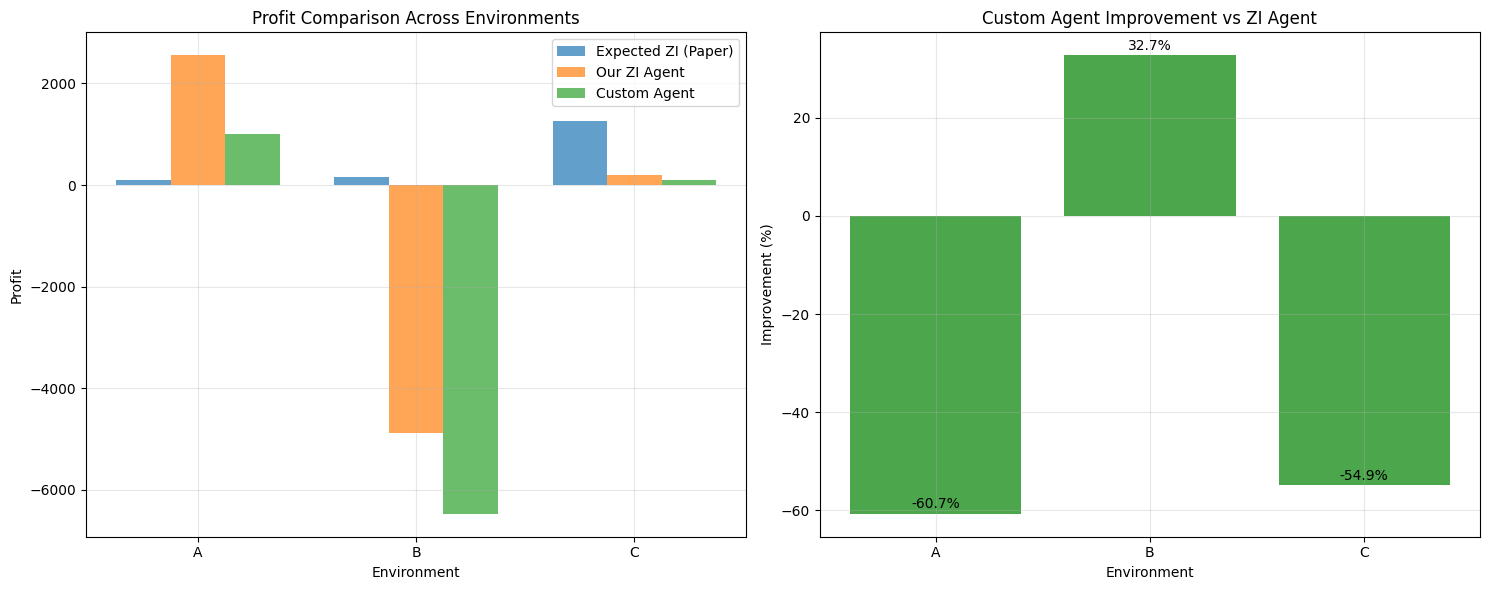

In [ ]:
# Create performance comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Profit comparison across environments
environments = comparison_table['Environment']
x = np.arange(len(environments))
width = 0.25

ax1.bar(x - width, comparison_table['Expected_ZI_Profit'], width, label='Expected ZI (Paper)', alpha=0.7)
ax1.bar(x, comparison_table['ZI_Agent_Profit'], width, label='Our ZI Agent', alpha=0.7)
ax1.bar(x + width, comparison_table['Custom_Agent_Profit'], width, label='Custom Agent', alpha=0.7)

ax1.set_xlabel('Environment')
ax1.set_ylabel('Profit')
ax1.set_title('Profit Comparison Across Environments')
ax1.set_xticks(x)
ax1.set_xticklabels(environments)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Improvement percentage
ax2.bar(environments, comparison_table['Improvement_Percentage'], color='green', alpha=0.7)
ax2.set_xlabel('Environment')
ax2.set_ylabel('Improvement (%)')
ax2.set_title('Custom Agent Improvement vs ZI Agent')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(comparison_table['Improvement_Percentage']):
    ax2.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Statistical Analysis

In [ ]:
# Statistical significance testing
from scipy import stats

def statistical_test(baseline_results, custom_results, env_name):
    baseline_profits = [trial['test_agent_profit'] for trial in baseline_results[env_name]['trial_results']]
    custom_profits = [trial['test_agent_profit'] for trial in custom_results[env_name]['trial_results']]
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(custom_profits, baseline_profits)
    
    # Effect size (Cohen's d)
    diff = np.array(custom_profits) - np.array(baseline_profits)
    pooled_std = np.sqrt((np.var(custom_profits) + np.var(baseline_profits)) / 2)
    cohens_d = np.mean(diff) / pooled_std if pooled_std > 0 else 0
    
    return {
        'environment': env_name,
        'baseline_mean': np.mean(baseline_profits),
        'custom_mean': np.mean(custom_profits),
        'baseline_std': np.std(baseline_profits),
        'custom_std': np.std(custom_profits),
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05
    }

# Run statistical tests for each environment
print("\nStatistical Analysis:")
print("=" * 80)

for env_name in framework.environments.keys():
    stats_result = statistical_test(baseline_results, custom_results, env_name)
    
    print(f"\nEnvironment {env_name}:")
    print(f"  Baseline: {stats_result['baseline_mean']:.2f} ± {stats_result['baseline_std']:.2f}")
    print(f"  Custom:   {stats_result['custom_mean']:.2f} ± {stats_result['custom_std']:.2f}")
    print(f"  t-statistic: {stats_result['t_statistic']:.3f}")
    print(f"  p-value: {stats_result['p_value']:.4f}")
    print(f"  Cohen's d: {stats_result['cohens_d']:.3f}")
    print(f"  Statistically significant: {'Yes' if stats_result['significant'] else 'No'}")


Statistical Analysis:

Environment A:
  Baseline: 2555.71 ± 5271.67
  Custom:   1004.82 ± 2359.77
  t-statistic: -0.761
  p-value: 0.4660
  Cohen's d: -0.380
  Statistically significant: No

Environment B:
  Baseline: -4878.53 ± 11321.55
  Custom:   -6474.08 ± 9061.80
  t-statistic: -0.337
  p-value: 0.7437
  Cohen's d: -0.156
  Statistically significant: No

Environment C:
  Baseline: 198.82 ± 1963.94
  Custom:   89.73 ± 1791.67
  t-statistic: -0.098
  p-value: 0.9237
  Cohen's d: -0.058
  Statistically significant: No


## Summary

This experiment framework allows you to:

1. **Test single agents** against 15 background agents (3 groups of 5)
2. **Compare performance** across three market environments (A, B, C) with different parameters
3. **Benchmark results** against the paper's expected values for ZI and TRON agents
4. **Run statistical analysis** to determine significance of performance differences
5. **Visualize results** for easy interpretation

To test your own agent:
1. Create a new agent class inheriting from `Agent`
2. Implement the required methods: `get_id()`, `take_action()`, `reset()`
3. Pass your agent class and parameters to `run_all_experiments()`
4. Analyze the results using the built-in comparison and visualization tools